## Outline
1. Modified SN class
2. Overall setup - What is the data, model, task
3. Plotting functions - 3d, contour
4. Individual algorithms and how they perform

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import cm
import matplotlib.colors

from matplotlib import animation, rc
from IPython.display import HTML

import numpy as np

# Modified Sigmoid Class

In [0]:
class SN:

  def __init__(self, w_init, b_init, algo): # scalar values (individual x)
    # this time not initialising to np.random. Instead use one of the initialisation techniques later (He/Xavier)
    self.w = w_init
    self.b = b_init
    # history variables (to track previous values to see how changing)
    self.w_h = []
    self.b_h = []
    self.e_h = []
    # Choose the algo of your choice this time (GD, Momentum GD, NAG, Adagrad, RMSProp, Adam)
    self.algo = algo

  # First time taking even w and b as input; not only x. Generally sigmoid was calculated at present location only. Now may need to calc. at other points too as in NAG
  def sigmoid(self, x, w= None, b = None):
    if w is None:
      w = self.w
    if b is None:
      b = self.b
    return 1. / (1. + np.exp(-(w*x + b)))

  def error(self, X, Y, w = None, b = None):
    if w is None:
      w = self.w
    if b is None:
      b = self.b
    err = 0
    # MSE
    for x,y in zip(X,Y):
      # Accumulating 
      err += 0.5 * (self.sigmoid(x,w,b)-y) ** 2
    return err

  def grad_w(self, x, y, w=None, b=None):
    if w is None:
      w = self.w
    if b is None:
      b = self.b
    y_pred = self.sigmoid(x, w, b)
    return (y_pred-y) * y_pred * (1-y_pred) * x

  def grad_b(self, x, y, w=None, b=None):
    if w is None:
      w = self.w
    if b is None:
      b = self.b
    y_pred = self.sigmoid(x, w, b)
    return (y_pred-y) * y_pred * (1-y_pred)

  def fit(self, X, Y, epochs = 100, eta = 0.01, gamma = 0.9, mini_batch_size = 100, eps = 1e-8,
          beta = 0.9, beta1 = 0.9, beta2 = 0.9
          ):
    
    self.w_h = []
    self.b_h = []
    self.e_h = []
    self.X = X 
    self.Y = Y

    if self.algo == "GD":
      for i in range(epochs):
        dw,db = 0,0
        for x,y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)
        # Batch GD
        self.w -= eta*dw / X.shape[0]
        self.b -= eta*db / X.shape[0]
        self.append_log()

    elif self.algo == "Momentum":
      # gamma = acceleration/amount of momentum we require
      v_w , v_b = 0, 0
      for i in range(epochs):
        dw,db = 0,0
        for x,y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)
        # exponentially decaying weighted sum
        # The 2 standard formulae for Momentum GD below
        v_w = gamma * v_w + eta * dw
        v_b = gamma * v_b + eta * db
        self.w -= v_w
        self.b -= v_b
        self.append_log()

    elif self.algo == "NAG":
      v_w , v_b = 0, 0
      for i in range(epochs):
        dw,db = 0,0
        # Update previous values
        v_w = gamma * v_w
        b_w = gamma * v_b
        for x,y in zip(X,Y):
          dw += self.grad_w(x,y,self.w-v_w, self.b - v_b) # First move weight by history and then find derivative at new point and again update weight there
          db += self.grad_b(x,y,self.w-v_w, self.b - v_b)
        v_w += eta*dw
        v_b += eta*db
        self.w -= v_w
        self.b -= v_b
        self.append_log()

    elif self.algo=="MiniBatch":
      for i in range(epochs):
        dw,db = 0,0
        points_seen = 0;
        for x,y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)
          if(points_seen%mini_batch_size == 0):
            self.w -= eta*dw / mini_batch_size
            self.b -= eta*db / mini_batch_size
            dw, db = 0, 0 # Obiviously start fresh for next mini batch so that can update. If don't make it zero, becomes equivalent to "Batch GD"
            self.append_log()

    elif self.algo == "AdaGrad":
      v_w , v_b = 0 , 0
      for i in range(epochs):
        dw,db = 0,0
        for x,y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)
        v_w += dw**2
        v_b += db**2
        self.w -= eta / np.sqrt(v_w) + eps * dw
        self.b -= eta / np.sqrt(v_b) + eps * db
        self.append_log()

    elif self.algo == "RMSProp":
      v_w , v_b = 0 , 0
      for i in range(epochs):
        dw,db = 0,0
        for x,y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)
        # To stop denominator from increasing continuously
        v_w = beta * v_w + (1-beta) * dw**2
        v_b = beta * v_b + (1-beta) * db**2
        self.w -= (eta / np.sqrt(v_w) + eps) * dw
        self.b -= (eta / np.sqrt(v_b) + eps) * db
        self.append_log()

    elif self.algo == "Adam":
      v_w , v_b = 0,0
      m_w, m_b = 0,0
      num_updates = 0
      for i in range(epochs):
        dw,db = 0,0
        for x,y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)
          num_updates += 1
          # exponential weighted sum of gradients
          m_w = beta * m_w + (1-beta1) * dw
          m_b = beta * m_b + (1-beta1) * db
          # exponential weighted sum of square of gradients
          v_w = beta * v_w + (1-beta2) * dw**2
          v_b = beta * v_b + (1-beta2) * db**2
          m_w_c = m_w/(1-np.power(beta1, num_updates))
          m_b_c = m_b/(1-np.power(beta1, num_updates))
          v_w_c = v_w/(1-np.power(beta2, num_updates))
          v_b_c = v_b/(1-np.power(beta2, num_updates))          
          self.w -= (eta / np.sqrt(v_w_c) + eps) * m_w_c
          self.b -= (eta / np.sqrt(v_b_c) + eps) * m_b_c
          self.append_log()

  def append_log(self):
    self.w_h.append(self.w)
    self.b_h.append(self.b)
    self.e_h.append(self.error(self.X, self.Y)) # Calc. current error for current w,b since not passing

#GD

In [0]:
X = np.asarray([0.5, 2.5])
Y = np.asarray([0.2,0.9])

algo = "GD"

# deterministic, not random
w_init = -2
b_init = -2

epochs = 1000
eta = 1 # learning rate

w_min = -7
w_max = 5

b_min = -5
b_max = 5

animation_frames = 20
plot_3d = True
plot_2d = False

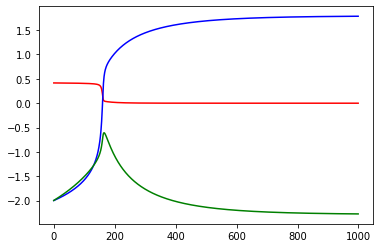

In [45]:
sn = SN(w_init, b_init, algo)
sn.fit(X, Y, epochs = epochs, eta = eta)
plt.plot(sn.e_h,'r')
plt.plot(sn.w_h,'b')
plt.plot(sn.b_h,'g')
plt.show()

Error (red) going close to zero after dropping

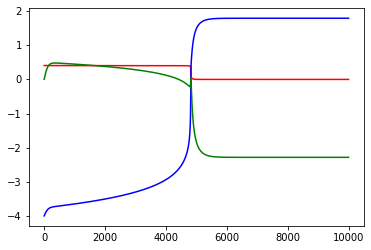

In [46]:
X = np.asarray([0.5, 2.5])
Y = np.asarray([0.2,0.9])

algo = "GD"

# deterministic, not random
w_init = -4
b_init = 0

epochs = 10000
eta = 1 # learning rate

w_min = -7
w_max = 5

b_min = -5
b_max = 5

animation_frames = 20
plot_3d = True
plot_2d = False


sn = SN(w_init, b_init, algo)
sn.fit(X, Y, epochs = epochs, eta = eta)
plt.plot(sn.e_h,'r')
plt.plot(sn.w_h,'b')
plt.plot(sn.b_h,'g')
plt.show()

# Momentum Based GD

Moves fast where gradient remains consistent and cancel out in places where gradient is variable


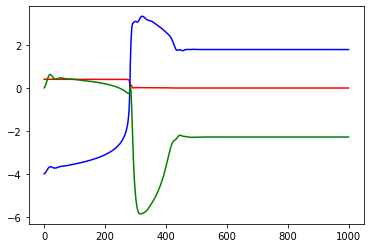

In [47]:
X = np.asarray([0.5, 2.5])
Y = np.asarray([0.2,0.9])

algo = "Momentum"

# deterministic, not random
w_init = -4
b_init = 0

epochs = 1000
eta = 1 # learning rate

w_min = -7
w_max = 5

b_min = -5
b_max = 5

animation_frames = 20
plot_3d = True
plot_2d = False


sn = SN(w_init, b_init, algo)
sn.fit(X, Y, epochs = epochs, eta = eta)
plt.plot(sn.e_h,'r')
plt.plot(sn.w_h,'b')
plt.plot(sn.b_h,'g')
plt.show()

Very rapid changes in loss. Doesn't take as many epochs to cross flat surface

**Notice GD (plot above this) took 10000 epochs to do the very same thing Momentum took only 1000 epochs for.**

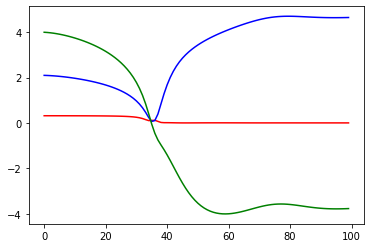

In [48]:
X = np.asarray([0.5, 2.5])
Y = np.asarray([0.2,0.9])

algo = "Momentum"

# deterministic, not random
w_init = 2.1
b_init = 4.0

epochs = 100
eta = 1 # learning rate

w_min = -7
w_max = 5

b_min = -5
b_max = 5

animation_frames = 20
plot_3d = True
plot_2d = False


sn = SN(w_init, b_init, algo)
sn.fit(X, Y, epochs = epochs, eta = eta)
plt.plot(sn.e_h,'r')
plt.plot(sn.w_h,'b')
plt.plot(sn.b_h,'g')
plt.show()

# NAG

Gradient not computed at current point but after taking one step. Add the first part, then find gradient, then add that part instead of adding both parts together

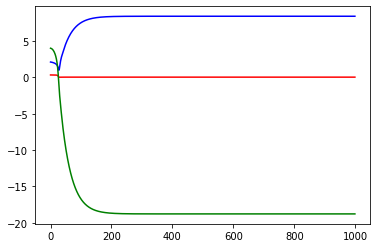

In [49]:
X = np.asarray([0.5, 2.5])
Y = np.asarray([0.2,0.9])

algo = "NAG"

# deterministic, not random
w_init = 2.1
b_init = 4.0

epochs = 1000
eta = 1 # learning rate

w_min = -7
w_max = 5

b_min = -5
b_max = 5

gamma = 0.8 # Acceleration rate

animation_frames = 20
plot_3d = True
plot_2d = False


sn = SN(w_init, b_init, algo)
sn.fit(X, Y, epochs = epochs, eta = eta, gamma = gamma)
plt.plot(sn.e_h,'r')
plt.plot(sn.w_h,'b')
plt.plot(sn.b_h,'g')
plt.show()

# Mini-batch GD

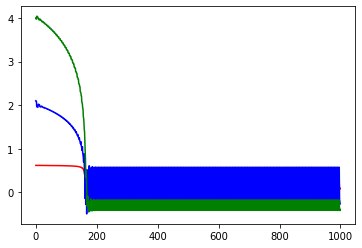

In [50]:
X = np.asarray([3.5, 0.35, 3.2, -2.0, 1.5, -0.5])
Y = np.asarray([0.5, 0.50, 0.5, 0.5, 0.3])

algo = "MiniBatch"

# deterministic, not random
w_init = 2.1
b_init = 4.0

epochs = 200
eta = 5 # learning rate

w_min = -7
w_max = 5

b_min = -5
b_max = 5

mini_batch_size = 1

animation_frames = 20
plot_3d = True
plot_2d = False


sn = SN(w_init, b_init, algo)
sn.fit(X, Y, epochs = epochs, eta = eta, mini_batch_size = mini_batch_size)
plt.plot(sn.e_h,'r')
plt.plot(sn.w_h,'b')
plt.plot(sn.b_h,'g')
plt.show()

Very high oscillations, too many updates - stochastic GD

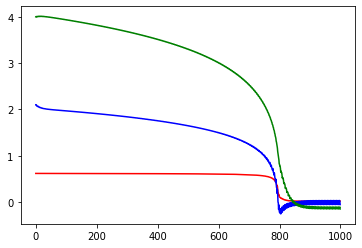

In [51]:
X = np.asarray([3.5, 0.35, 3.2, -2.0, 1.5, -0.5])
Y = np.asarray([0.5, 0.50, 0.5, 0.5, 0.3])

algo = "MiniBatch"

# deterministic, not random
w_init = 2.1
b_init = 4.0

epochs = 200
eta = 5 # learning rate

w_min = -7
w_max = 5

b_min = -5
b_max = 5

mini_batch_size = 5

animation_frames = 20
plot_3d = True
plot_2d = False


sn = SN(w_init, b_init, algo)
sn.fit(X, Y, epochs = epochs, eta = eta, mini_batch_size = mini_batch_size)
plt.plot(sn.e_h,'r')
plt.plot(sn.w_h,'b')
plt.plot(sn.b_h,'g')
plt.show()

Still some oscillations, but fewer oscillations since fewer updates

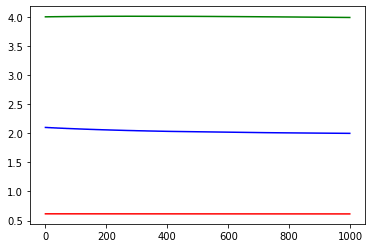

In [52]:
X = np.asarray([3.5, 0.35, 3.2, -2.0, 1.5, -0.5])
Y = np.asarray([0.5, 0.50, 0.5, 0.5, 0.3])

algo = "MiniBatch"

# deterministic, not random
w_init = 2.1
b_init = 4.0

epochs = 200
eta = 5 # learning rate

w_min = -7
w_max = 5

b_min = -5
b_max = 5

mini_batch_size = 100

animation_frames = 20
plot_3d = True
plot_2d = False


sn = SN(w_init, b_init, algo)
sn.fit(X, Y, epochs = epochs, eta = eta, mini_batch_size = mini_batch_size)
plt.plot(sn.e_h,'r')
plt.plot(sn.w_h,'b')
plt.plot(sn.b_h,'g')
plt.show()

**Note way way lesser oscillations than stochastic GD (mini-batch-size = 1)**

# Adagrad

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


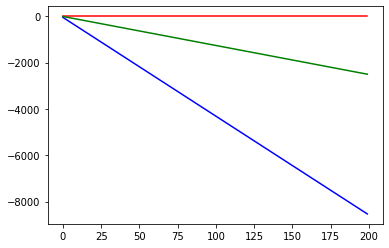

In [55]:
X = np.asarray([3.5, 0.35, 3.2, -2.0, 1.5, -0.5])
Y = np.asarray([0.5, 0.50, 0.5, 0.5, 0.3])

algo = "AdaGrad"

# deterministic, not random
w_init = -6
b_init = 4.0

epochs = 200
eta = 0.5 # learning rate
eps = 1e-8

w_min = -7
w_max = 5

b_min = -7
b_max = 5


animation_frames = 20
plot_3d = True
plot_2d = False


sn = SN(w_init, b_init, algo)
sn.fit(X, Y, epochs = epochs, eta = eta)
plt.plot(sn.e_h,'r')
plt.plot(sn.w_h,'b')
plt.plot(sn.b_h,'g')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


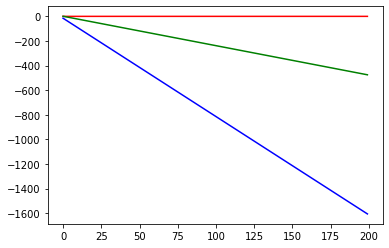

In [62]:
X = np.asarray([3.5, 0.35, 3.2, -2.0, 1.5, -0.5])
Y = np.asarray([0.5, 0.50, 0.5, 0.5, 0.3])

algo = "AdaGrad"

# deterministic, not random
w_init = -6
b_init = 4.0

epochs = 200
gamma = 0.9
eta = 0.1 # learning rate
eps = 1e-8

w_min = -7
w_max = 5

b_min = -7
b_max = 5


animation_frames = 20
plot_3d = True
plot_2d = False


sn = SN(w_init, b_init, algo)
sn.fit(X, Y, epochs = epochs, eta = eta, gamma = gamma)
plt.plot(sn.e_h,'r')
plt.plot(sn.w_h,'b')
plt.plot(sn.b_h,'g')
plt.show()

# RMSProp

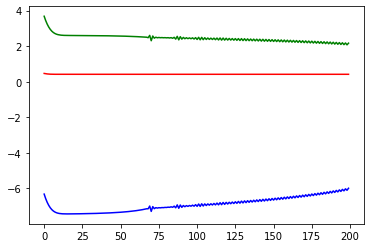

In [67]:
X = np.asarray([3.5, 0.35, 3.2, -2.0, 1.5, -0.5])
Y = np.asarray([0.5, 0.50, 0.5, 0.5, 0.3])

algo = "RMSProp"

# deterministic, not random
w_init = -6
b_init = 4.0

epochs = 200
gamma = 0.9
eta = 0.1 # learning rate
eps = 1e-8

w_min = -7
w_max = 5

b_min = -7
b_max = 5


animation_frames = 20
plot_3d = True
plot_2d = False


sn = SN(w_init, b_init, algo)
sn.fit(X, Y, epochs = epochs, eta = eta, gamma = gamma)
plt.plot(sn.e_h,'r')
plt.plot(sn.w_h,'b')
plt.plot(sn.b_h,'g')
plt.show()

Note how different from Adagrad, doesn't saturate; supports lower learning rates

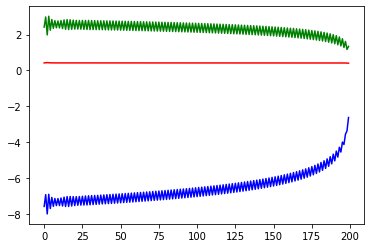

In [66]:
X = np.asarray([3.5, 0.35, 3.2, -2.0, 1.5, -0.5])
Y = np.asarray([0.5, 0.50, 0.5, 0.5, 0.3])

algo = "RMSProp"

# deterministic, not random
w_init = -6
b_init = 4.0

epochs = 200
gamma = 0.9
eta = 0.5 # learning rate
eps = 1e-8

w_min = -7
w_max = 5

b_min = -7
b_max = 5


animation_frames = 20
plot_3d = True
plot_2d = False


sn = SN(w_init, b_init, algo)
sn.fit(X, Y, epochs = epochs, eta = eta, gamma = gamma)
plt.plot(sn.e_h,'r')
plt.plot(sn.w_h,'b')
plt.plot(sn.b_h,'g')
plt.show()

But bad if learning rates are higher - too many oscillations

# Adam

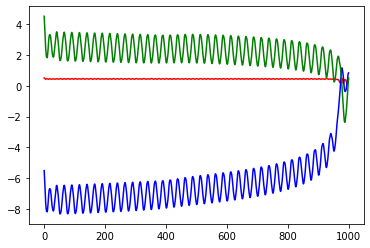

In [73]:
X = np.asarray([3.5, 0.35, 3.2, -2.0, 1.5, -0.5])
Y = np.asarray([0.5, 0.50, 0.5, 0.5, 0.3])

algo = "Adam"

# deterministic, not random
w_init = -6
b_init = 4.0

epochs = 200
gamma = 0.9
eta = 0.5 # learning rate
eps = 1e-8

w_min = -7
w_max = 5

b_min = -7
b_max = 5


animation_frames = 20
plot_3d = True
plot_2d = False


sn = SN(w_init, b_init, algo)
sn.fit(X, Y, epochs = epochs, eta = eta, gamma = gamma)
plt.plot(sn.e_h,'r')
plt.plot(sn.w_h,'b')
plt.plot(sn.b_h,'g')
plt.show()